## Project PD2

### import packages

In [106]:
import datascience as ds
from datascience import *
import numpy as np
from collections import Counter
from graphviz import Source
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.externals import joblib
%matplotlib inline

### tweets data loaded into Jupyter Notebook as Table object

In [107]:
df1 = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df2 = ds.Table.read_table('ClimateBalancedDS2.csv', sep=',')
df = df1.append(df2)
test_index = np.random.choice(df.num_rows, 100, replace=False)
train_val_index = [i for i in np.arange(df.num_rows) if i not in test_index]
test_data = df.take[test_index]
df = df.take[train_val_index]
X = list(df['Text'])
y = list(df['Support'])

### A description of all model enhancements incorporated into the construction of PD2.






#### used parameters

- CountVector
    - token_pattern = "(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}"
    - analyzer = 'word'
    - stop_words = 
    - min_df = 3
    - ngram_range=(1,2)
- DecisionTree
    - criterion='entropy'
    - max_depth = 
    - min_samples_leaf = 2

### A description of all model parameters you tried and the associated Stratified k-fold cross validation results for each model parameter choice based on the combined data set (DS1 + DS2)

 - max_depth=range(1, 15)
 - stop_words:
     - default in CountVectorizer: 'english'
     - user_defined: ['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https']
     - the top 30 most common words in DS1+DS2 tweets (chosen)
     
code and test results as follows:

### Check whether the data distribution is balanced

In [108]:
def check(sentiment, index, note='training'):
    if sentiment==0:
        label = 'not supportive'
    else:
        label = 'supportive'
    print('There are {} '.format(df.take(index).where('Support', 
          are.equal_to(sentiment)).size[0][0])+label+' tweets in the '+note+' set.')

#### Model Building

In [109]:
def custom_split(train_index, test_index):
    trainingset = df.take(train_index)
    testingset = df.take(test_index)    
        
    X_train= list(trainingset['Text'])
    y_train= list(trainingset['Support'])
    X_test= list(testingset['Text'])
    y_test= list(testingset['Support'])
    
    return X_train, X_test, y_train, y_test

### classifier

In [110]:
def classifier(X_train, y_train, X_test, fold, max_depth, min_samples_leaf, stop_words, overfit_risk=False):
    # token_pattern='(([#@]|[0-9]|[a-z]|[A-Z])+)'
    clf = Pipeline(
        [
            ('vect', CountVectorizer(token_pattern="(?!RT|rt|\d+)[@#]*[\w\'_-]{2,100}",
                                     analyzer = 'word',
                                     stop_words = stop_words,
                                     min_df = 3,
                                     ngram_range=(1,2))),
            ('clf', DecisionTreeClassifier(criterion='entropy',
                                           random_state = 100,
                                           max_depth = max_depth,
                                           min_samples_leaf = min_samples_leaf))
        ])
    clf.fit(X_train, y_train)
    feature_names = clf.named_steps['vect'].get_feature_names()
    try:
        dot_data = tree.export_graphviz(clf.named_steps['clf'], out_file=None, 
                                        feature_names=feature_names)
        graph = Source(dot_data)
        graph.render('ClimateClassifier-Fold_{}'.format(fold))
    except Exception as e:
        print(e)
    predicted_y_train = clf.predict(X_train)
    predicted_y_test = clf.predict(X_test)
    # save as pickle
    if overfit_risk:
        joblib.dump(clf, 'ClimateTeam7PD2_maxdepth{}.pkl'.format(max_depth))
    else:
        joblib.dump(clf, 'ClimateTeam7PD2.pkl')
    return predicted_y_train, predicted_y_test

### evaluation

In [111]:
def eval_results(predicted_y_train, y_train, predicted_y_test, y_test):
    accuracy_s = accuracy_score(y_test, predicted_y_test)
    precision_s = precision_score(y_test, predicted_y_test)
    recall_s = recall_score(y_test, predicted_y_test)
    f1_s = f1_score(y_test, predicted_y_test)
    cm_train = confusion_matrix(y_train, predicted_y_train)
    cm_test = confusion_matrix(y_test, predicted_y_test)  
    
    print('Accuracy Score:', accuracy_s)
    print("Precision Score:", precision_s)
    print("Recall Score:", recall_s)
    print("f1 Score:", f1_s)
    print('confusion_matrix of training set is: \n', cm_train, '\n')
    print('confusion_matrix of testing set is: \n', cm_test, '\n')
    print(classification_report(y_test, predicted_y_test))
    
    classes = ['not supportive', 'supportive']
    sns.heatmap(cm_train, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of training set')
    plt.show()
    sns.heatmap(cm_test, annot=True, cmap='Blues', yticklabels=classes, xticklabels=classes)
    plt.title('confusion matrix of testing set')
    plt.show()
    return accuracy_s, precision_s, recall_s, f1_s

### k-fold

In [112]:
def k_fold_evaluate(X, y, max_depth, min_samples_leaf, stop_words, print_eval=True, overfit_risk=False):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
    
    # build model and collect results
    for val_index, test_index in skf.split(X, y):
        X_train, X_val, y_train, y_val = custom_split(val_index, test_index)
        
        predicted_y_train, predicted_y_val = classifier(X_train=X_train, y_train=y_train, 
                                                          X_test=X_val, fold=fold,
                                                          max_depth = max_depth,
                                                          min_samples_leaf = min_samples_leaf,
                                                          stop_words = stop_words,
                                                          overfit_risk=overfit_risk)
        metrics_df={}
        if print_eval:
            print('\nFold: {}'.format(fold))
            accuracy_s, precision_s, recall_s, f1_s = eval_results(predicted_y_train, y_train, predicted_y_val, y_val)

            accuracy.append(accuracy_s)
            precision.append(precision_s)
            recall.append(recall_s)
            f1.append(f1_s)

            metrics_df = pd.DataFrame(
                        {
                            'accuracy': accuracy,
                            'precision': precision,
                            'recall':recall,
                            'f1':f1
                        }
                    )
            fold += 1
    return metrics_df

### Tests: max_depth : 1-15

#### test1: stop-words: default

In [113]:
test_X = list(test_data['Text'])
test_y = list(test_data['Support'])

In [117]:
f1_lst_test1 = []
f1_lst_train1 = []
for d in range(1, 15):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=2, stop_words='english', print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test1.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train1.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.6019417475728155
train f1
0.6012009890498058
maxdepth= 2
test f1
0.6608695652173913
train f1
0.6829733163913596
maxdepth= 3
test f1
0.6666666666666666
train f1
0.6910466582597731
maxdepth= 4
test f1
0.6666666666666666
train f1
0.6962822936357909
maxdepth= 5
test f1
0.6782608695652174
train f1
0.7033312382149591
maxdepth= 6
test f1
0.6842105263157895
train f1
0.7010834926704909
maxdepth= 7
test f1
0.6956521739130435
train f1
0.7089410272669627
maxdepth= 8
test f1
0.6956521739130435
train f1
0.7140600315955766
maxdepth= 9
test f1
0.6956521739130435
train f1
0.7180296810862015
maxdepth= 10
test f1
0.6842105263157895
train f1
0.7214669617451785
maxdepth= 11
test f1
0.6956521739130435
train f1
0.7292057535959976
maxdepth= 12
test f1
0.6956521739130435
train f1
0.7314465408805032
maxdepth= 13
test f1
0.6956521739130435
train f1
0.7343208320201702
maxdepth= 14
test f1
0.7017543859649122
train f1
0.7359143846395971


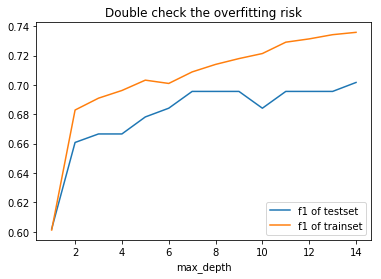

In [119]:
plt.plot(np.arange(1,15), f1_lst_test1, label='f1 of testset')
plt.plot(np.arange(1,15), f1_lst_train1, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

#### test2: stop_words: ['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https']

In [121]:
f1_lst_test2 = []
f1_lst_train2 = []
for d in range(1, 15):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=2, 
                    stop_words=['a', 'an', 'the', 'it', 'is', 'are', 'be', 'of', 'this', 'that', 'RT', 'rt','https'], 
                    print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test2.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train2.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.6019417475728155
train f1
0.6012009890498058
maxdepth= 2
test f1
0.6608695652173913
train f1
0.6829733163913596
maxdepth= 3
test f1
0.6666666666666665
train f1
0.7001540832049308
maxdepth= 4
test f1
0.6666666666666665
train f1
0.7059902200488998
maxdepth= 5
test f1
0.6724137931034483
train f1
0.704040087691826
maxdepth= 6
test f1
0.6608695652173913
train f1
0.704713049054184
maxdepth= 7
test f1
0.6608695652173913
train f1
0.7053915275994865
maxdepth= 8
test f1
0.6724137931034483
train f1
0.7151819322459222
maxdepth= 9
test f1
0.6724137931034483
train f1
0.7177522349936144
maxdepth= 10
test f1
0.6724137931034483
train f1
0.727102219443576
maxdepth= 11
test f1
0.6608695652173913
train f1
0.7317839195979898
maxdepth= 12
test f1
0.6551724137931034
train f1
0.74280408542247
maxdepth= 13
test f1
0.6666666666666665
train f1
0.747896540978498
maxdepth= 14
test f1
0.6608695652173913
train f1
0.7457735247208931


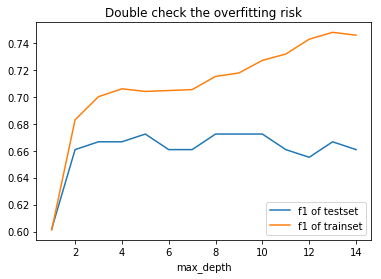

In [122]:
plt.plot(np.arange(1,15), f1_lst_test2, label='f1 of testset')
plt.plot(np.arange(1,15), f1_lst_train2, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

#### test3: stop_words: most common words in DS1+DS2 tweets

In [123]:
stop_w = [i[0] for i in Counter([word for sentence in X for word in sentence.split() 
                                 if 'climate' not in word.lower() 
                                 and word.isalpha() 
                                 and len(word)>1]).most_common()[:30]]
stop_w

['the',
 'to',
 'RT',
 'of',
 'change',
 'is',
 'and',
 'in',
 'that',
 'on',
 'for',
 'are',
 'you',
 'we',
 'The',
 'it',
 'this',
 'about',
 'be',
 'by',
 'have',
 'not',
 'will',
 'our',
 'from',
 'as',
 'can',
 'with',
 'all',
 'We']

In [124]:
f1_lst_test3 = []
f1_lst_train3 = []
for d in range(1, 15):
    k_fold_evaluate(X, y, max_depth=d, min_samples_leaf=2, 
                    stop_words=stop_w, 
                    print_eval=False, overfit_risk=True)
    clf_tmp = joblib.load('ClimateTeam7PD2_maxdepth{}.pkl'.format(d))
    print('maxdepth=', d)
    # test
    y_pred = clf_tmp.predict(test_X)
    print('test f1')
    print(f1_score(y_pred=y_pred, y_true=test_y))
    f1_lst_test3.append(f1_score(y_pred=y_pred, y_true=test_y))
    # train_val
    y_pred = clf_tmp.predict(X)
    print('train f1')
    print(f1_score(y_pred=y_pred, y_true=y))
    f1_lst_train3.append(f1_score(y_pred=y_pred, y_true=y))

maxdepth= 1
test f1
0.6019417475728155
train f1
0.6012009890498058
maxdepth= 2
test f1
0.6608695652173913
train f1
0.6829733163913596
maxdepth= 3
test f1
0.6666666666666666
train f1
0.6925750394944707
maxdepth= 4
test f1
0.6666666666666666
train f1
0.6969124133585382
maxdepth= 5
test f1
0.6724137931034483
train f1
0.70282131661442
maxdepth= 6
test f1
0.6724137931034483
train f1
0.7016661427224143
maxdepth= 7
test f1
0.6896551724137931
train f1
0.7094954559699153
maxdepth= 8
test f1
0.6896551724137931
train f1
0.7131249999999999
maxdepth= 9
test f1
0.6896551724137931
train f1
0.716875
maxdepth= 10
test f1
0.6896551724137931
train f1
0.7177722152690864
maxdepth= 11
test f1
0.7008547008547009
train f1
0.7199248120300753
maxdepth= 12
test f1
0.6896551724137931
train f1
0.7233238904627006
maxdepth= 13
test f1
0.7008547008547009
train f1
0.725434439178515
maxdepth= 14
test f1
0.706896551724138
train f1
0.7292782855341946


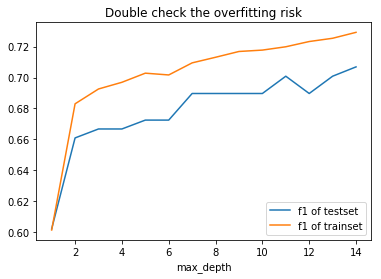

In [125]:
plt.plot(np.arange(1,15), f1_lst_test3, label='f1 of testset')
plt.plot(np.arange(1,15), f1_lst_train3, label='f1 of trainset')
plt.xlabel('max_depth')
plt.title('Double check the overfitting risk')
plt.legend(loc='lower right')
plt.show()

## Final result


Fold: 1
Accuracy Score: 0.6229802513464991
Precision Score: 0.6175637393767706
Recall Score: 0.7440273037542662
f1 Score: 0.6749226006191951
confusion_matrix of training set is: 
 [[649 407]
 [209 961]] 

confusion_matrix of testing set is: 
 [[129 135]
 [ 75 218]] 

             precision    recall  f1-score   support

          0       0.63      0.49      0.55       264
          1       0.62      0.74      0.67       293

avg / total       0.62      0.62      0.62       557



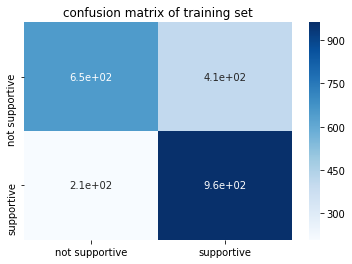

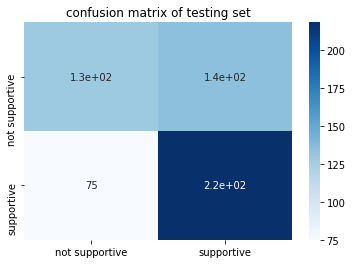


Fold: 2
Accuracy Score: 0.6157989228007181
Precision Score: 0.6064690026954178
Recall Score: 0.7679180887372014
f1 Score: 0.6777108433734939
confusion_matrix of training set is: 
 [[619 437]
 [200 970]] 

confusion_matrix of testing set is: 
 [[118 146]
 [ 68 225]] 

             precision    recall  f1-score   support

          0       0.63      0.45      0.52       264
          1       0.61      0.77      0.68       293

avg / total       0.62      0.62      0.61       557



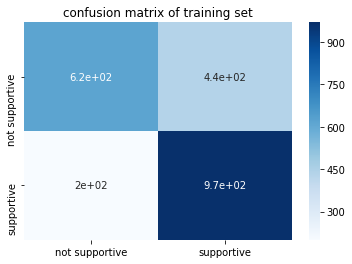

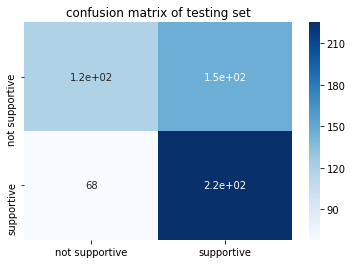


Fold: 3
Accuracy Score: 0.6481149012567325
Precision Score: 0.6456456456456456
Recall Score: 0.7337883959044369
f1 Score: 0.6869009584664537
confusion_matrix of training set is: 
 [[649 407]
 [220 950]] 

confusion_matrix of testing set is: 
 [[146 118]
 [ 78 215]] 

             precision    recall  f1-score   support

          0       0.65      0.55      0.60       264
          1       0.65      0.73      0.69       293

avg / total       0.65      0.65      0.64       557



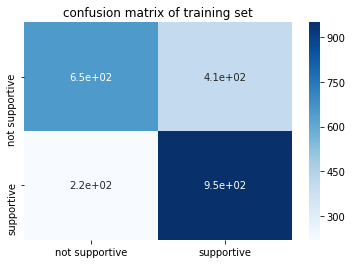

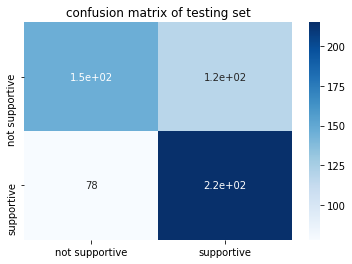


Fold: 4
Accuracy Score: 0.6762589928057554
Precision Score: 0.6609195402298851
Recall Score: 0.7876712328767124
f1 Score: 0.71875
confusion_matrix of training set is: 
 [[612 444]
 [216 955]] 

confusion_matrix of testing set is: 
 [[146 118]
 [ 62 230]] 

             precision    recall  f1-score   support

          0       0.70      0.55      0.62       264
          1       0.66      0.79      0.72       292

avg / total       0.68      0.68      0.67       556



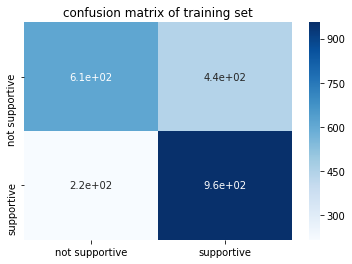

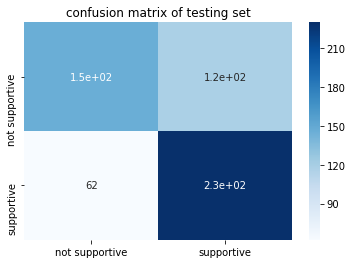


Fold: 5
Accuracy Score: 0.6312949640287769
Precision Score: 0.623229461756374
Recall Score: 0.7534246575342466
f1 Score: 0.6821705426356589
confusion_matrix of training set is: 
 [[655 401]
 [242 929]] 

confusion_matrix of testing set is: 
 [[131 133]
 [ 72 220]] 

             precision    recall  f1-score   support

          0       0.65      0.50      0.56       264
          1       0.62      0.75      0.68       292

avg / total       0.63      0.63      0.62       556



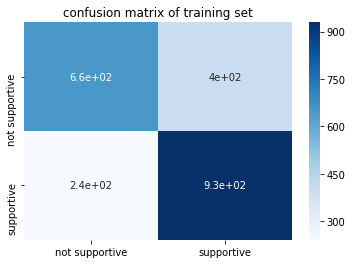

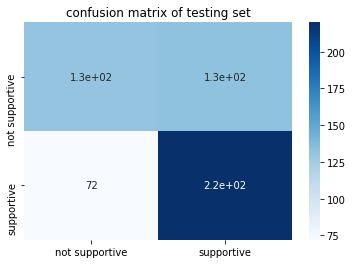

,accuracy,precision,recall,f1
0,0.622980,0.617564,0.744027,0.674923
1,0.615799,0.606469,0.767918,0.677711
2,0.648115,0.645646,0.733788,0.686901
3,0.676259,0.660920,0.787671,0.718750
4,0.631295,0.623229,0.753425,0.682171


In [126]:
k_fold_evaluate(X, y, max_depth=15, min_samples_leaf=2, 
                    stop_words=stop_w, 
                    print_eval=True, overfit_risk=False)

In [172]:
clf2 = joblib.load('ClimateTeam7PD2.pkl')

In [215]:
df1 = ds.Table.read_table('Climate1SupportiveLevel.csv', sep=',')
df2 = ds.Table.read_table('ClimateBalancedDS2.csv', sep=',')
df = df1.append(df2)
X = list(df['Text'])
y = list(df['Support'])
y_pred = clf_tmp.predict(X)
f1_score(y, y_pred)

0.728488902401946